# 1. Load Data

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os                 #get access to input files

from scipy import stats
from scipy.stats import norm,skew

from collections import Counter

import warnings
warnings.filterwarnings('ignore')


#read train file
train_data = pd.read_csv('train_cab.csv',encoding='utf-8')
train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [2]:
train_data.info(),train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        16043 non-null  object 
 1   pickup_datetime    16067 non-null  object 
 2   pickup_longitude   16067 non-null  float64
 3   pickup_latitude    16067 non-null  float64
 4   dropoff_longitude  16067 non-null  float64
 5   dropoff_latitude   16067 non-null  float64
 6   passenger_count    16012 non-null  float64
dtypes: float64(5), object(2)
memory usage: 878.8+ KB


(None, (16067, 7))

In [3]:
#read test file
test_data = pd.read_csv('test.csv',encoding='utf-8')
test_data.info(),test_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_datetime    9914 non-null   object 
 1   pickup_longitude   9914 non-null   float64
 2   pickup_latitude    9914 non-null   float64
 3   dropoff_longitude  9914 non-null   float64
 4   dropoff_latitude   9914 non-null   float64
 5   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


(None, (9914, 6))

In [4]:
#select target = y and inputs = x
y = train_data['fare_amount']

#feature =['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']
x = train_data.drop(columns =['fare_amount']).copy()
cols = list(x.columns)

for i in range(len(cols)):
    print(f"{cols[i]}\t{x[cols[i]][0]}")

train_data.describe()

pickup_datetime	2009-06-15 17:26:21 UTC
pickup_longitude	-73.844311
pickup_latitude	40.721319
dropoff_longitude	-73.84161
dropoff_latitude	40.712278000000005
passenger_count	1.0


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


# 2. Preprocessing

In [5]:
#as DataTime is in object dataType, we are converting it into date-time format

data_file = [train_data,test_data]
for i in data_file:
    i['pickup_datetime'] = pd.to_datetime(i['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC',errors='coerce')

train_data.dtypes, test_data.dtypes

(fare_amount                  object
 pickup_datetime      datetime64[ns]
 pickup_longitude            float64
 pickup_latitude             float64
 dropoff_longitude           float64
 dropoff_latitude            float64
 passenger_count             float64
 dtype: object,
 pickup_datetime      datetime64[ns]
 pickup_longitude            float64
 pickup_latitude             float64
 dropoff_longitude           float64
 dropoff_latitude            float64
 passenger_count               int64
 dtype: object)

In [6]:
#for plots convert object type to float or int
train_data['fare_amount'] = pd.to_numeric(train_data['fare_amount'], errors='coerce', downcast='float')
train_data['fare_amount'] = train_data['fare_amount'].replace({0:np.nan})
#for passenger count, first fill the NA with 0 as .astype cannot convert infinite values or NA into integer type

train_data['passenger_count'] = train_data['passenger_count'].fillna(0)
train_data['passenger_count'] = train_data['passenger_count'].astype(int)
    
train_data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        16041 non-null  float32       
 1   pickup_datetime    16066 non-null  datetime64[ns]
 2   pickup_longitude   16067 non-null  float64       
 3   pickup_latitude    16067 non-null  float64       
 4   dropoff_longitude  16067 non-null  float64       
 5   dropoff_latitude   16067 non-null  float64       
 6   passenger_count    16067 non-null  int32         
dtypes: datetime64[ns](1), float32(1), float64(4), int32(1)
memory usage: 753.3 KB


<h3>Missing Values

In [7]:
#to ignore warning, import warnings
col = ['fare_amount','passenger_count']
for i in col:
    train_data[i].fillna((train_data[i].mean()),inplace=True)
    
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        16067 non-null  float32       
 1   pickup_datetime    16066 non-null  datetime64[ns]
 2   pickup_longitude   16067 non-null  float64       
 3   pickup_latitude    16067 non-null  float64       
 4   dropoff_longitude  16067 non-null  float64       
 5   dropoff_latitude   16067 non-null  float64       
 6   passenger_count    16067 non-null  int32         
dtypes: datetime64[ns](1), float32(1), float64(4), int32(1)
memory usage: 753.3 KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pickup_datetime    9914 non-null   datetime64[ns]
 1   pickup_longitude   9914 non-null   float64       
 2   pickup_latitude    9914 non-null   float64       
 3   dropoff_longitude  9914 non-null   float64       
 4   dropoff_latitude   9914 non-null   float64       
 5   passenger_count    9914 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 464.8 KB


In [9]:
#to fill missing value in train_data['pickup_datetime']
#train_data = train_data.set_index(['pickup_datetime']).resample('D').mean()
#train_data['pickup_datetime'].resample('D').mean()
train_data = train_data.dropna(subset= ['pickup_datetime'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16066 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fare_amount        16066 non-null  float32       
 1   pickup_datetime    16066 non-null  datetime64[ns]
 2   pickup_longitude   16066 non-null  float64       
 3   pickup_latitude    16066 non-null  float64       
 4   dropoff_longitude  16066 non-null  float64       
 5   dropoff_latitude   16066 non-null  float64       
 6   passenger_count    16066 non-null  int32         
dtypes: datetime64[ns](1), float32(1), float64(4), int32(1)
memory usage: 878.6 KB


In [10]:
#mean is the best method, impute missing values with mean for pickup & dropoff latitude & longitude 

for i in data_file:
    i['pickup_longitude'] = i['pickup_longitude'].fillna(i['pickup_longitude'].mean())
    i['pickup_latitude'] = i['pickup_latitude'].fillna(i['pickup_latitude'].mean())
    i['dropoff_longitude'] = i['dropoff_longitude'].fillna(i['dropoff_longitude'].mean())
    i['dropoff_latitude'] = i['dropoff_latitude'].fillna(i['dropoff_latitude'].mean())

# Outlier Analysis

In [11]:
#save the data at another place with different name
df = train_data.copy()
train_data = train_data.copy()

<h3>Max number of passengers sit in a cab is 6

In [12]:
#to check passenger_count variable so that it can be converted into a categorical variable
#Fetching records having passenger count greater than 4

for i in range(4,11):
    print('passenger count: '+str(i)+'={}'.format(sum(train_data['passenger_count']==i)))

passenger count: 4=329
passenger count: 5=1045
passenger count: 6=302
passenger count: 7=0
passenger count: 8=0
passenger count: 9=0
passenger count: 10=0


In [13]:
#find passenger_count >6
train_data[train_data['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.500000,2011-07-24 01:14:35,0.000000,0.000000,0.000000,0.000000,236
263,4.900000,2010-07-12 09:44:33,-73.983249,40.734655,-73.991278,40.738918,456
293,6.100000,2011-01-18 23:48:00,-74.006642,40.738927,-74.010828,40.717907,5334
356,8.500000,2013-06-18 10:27:05,-73.992108,40.764203,-73.973000,40.762695,535
386,8.100000,2009-08-21 19:35:05,-73.960853,40.761557,-73.976335,40.748361,354
413,15.015864,2013-09-12 11:32:00,-73.982060,40.772705,-73.956213,40.771777,55
971,10.100000,2010-11-21 01:41:00,-74.004500,40.742143,-73.994330,40.720412,554
1007,3.700000,2010-12-14 14:46:00,-73.969157,40.759000,-73.968763,40.764617,53
1043,5.700000,2012-08-22 22:08:29,-73.973573,40.760184,-73.953564,40.767392,35
1107,4.900000,2009-08-08 21:50:50,-73.988977,40.721068,-73.982368,40.732064,345


In [14]:
#find passenger_count <1
train_data[train_data['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
31,22.540001,2015-06-21 21:46:34,-74.010483,40.717667,-73.985771,40.660366,0
64,7.300000,2011-11-07 10:47:40,-74.003919,40.753019,-73.992368,40.735362,0
82,8.500000,2013-06-14 08:27:43,-73.953710,40.790813,-73.957015,40.777676,0
97,9.000000,2014-12-07 12:26:00,-73.984977,40.752122,-74.000925,40.757982,0
112,35.000000,2012-12-06 18:05:00,-73.953310,40.787772,-73.944352,40.719772,0
...,...,...,...,...,...,...,...
15286,4.900000,2012-03-20 22:23:34,-73.971808,40.760143,-73.962027,40.767677,0
15514,6.500000,2012-02-12 02:03:50,-73.999342,40.718872,-73.984112,40.725242,0
15554,6.500000,2011-08-03 08:31:19,-73.991700,40.750100,-73.981000,40.750900,0
15919,16.500000,2011-10-17 08:58:54,0.000000,0.000000,-73.999700,40.734500,0


In [15]:
#drop passenger count < 1 and passenger count > 6
data_file = [train_data,test_data]
for i in data_file:
    i.drop(i[i['passenger_count']>6].index,axis=0,inplace=True)
    i.drop(i[i['passenger_count']<1].index,axis=0,inplace=True)

<h3>Fare amount is not negative or zero

In [16]:
#for the fare amount with negative values or less than 1
train_data[train_data['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10,-73.789450,40.643498,-73.788665,40.641952,1
2486,-2.50,2015-03-22 05:14:27,-74.000031,40.720631,-73.999809,40.720539,1
2780,0.01,2015-05-01 15:38:41,-73.939041,40.713963,-73.941673,40.713997,1
13032,-3.00,2013-08-30 08:57:10,-73.995062,40.740755,-73.995885,40.741357,4


In [17]:
#remove the values below 0
train_data.drop(train_data[train_data['fare_amount']<1].index,axis=0,inplace=True)

In [18]:
train_data['fare_amount'].sort_values(ascending=False)

1015     54343.00
1072      4343.00
607        453.00
980        434.00
1335       180.00
           ...   
9621         2.50
13488        2.50
7728         2.50
14304        2.50
1427         1.14
Name: fare_amount, Length: 15929, dtype: float32

In [19]:
# consider the fare_amount>453 as outlier and drop it
train_data.drop(train_data[train_data['fare_amount']>453].index,axis=0,inplace=True)


In [20]:
#save numeric data names

#Extract quartiles
#q75, q25 = np.percentile(train_data['fare_amount'],[75,25])
    
#calculate IQR
#iqr = q75 - q25
    
#Calculate inner and outer fence
#lower = q25 -(iqr*1.5)
#upper = q75 +(iqr*1.5)
    
#drop the outliers
   
#train_data.drop(train_data[train_data['fare_amount']<lower].index,axis=0,inplace=True)
#train_data.drop(train_data[train_data['fare_amount']>upper].index,axis=0,inplace=True)


    
#calculate missing value
missing_val = pd.DataFrame(train_data.isnull().sum())

missing_val


,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [21]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15927.000000,15927.000000,15927.000000,15927.000000,15927.000000,15927.000000
mean,11.381999,-72.468059,39.917640,-72.458313,39.895544,1.649714
std,10.807326,10.561604,6.826850,10.589416,6.197609,1.265982
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377,1.000000
25%,6.000000,-73.992143,40.734946,-73.991182,40.734681,1.000000
50%,8.500000,-73.981675,40.752640,-73.980155,40.753567,1.000000
75%,12.500000,-73.966801,40.767406,-73.963604,40.768030,2.000000
max,453.000000,40.766125,401.083332,40.802437,41.366138,6.000000


<h3><ul>
<li>Pickup and dropoff latitude should be (-90 to 90).   
    <li>Pickup and dropoff longitude should be (-180 to 180)</ul>


In [22]:
#data_file = [train_data,test_data]
latitude = ['pickup_latitude','dropoff_latitude']
longitude = ['pickup_longitude','dropoff_longitude']

for i in data_file:
    #latitude(-90 to 90)
    for j in latitude:
        i = i.drop(i[i[j]<-90].index,axis=0)
        i = i.drop(i[i[j]>90].index,axis=0)
                             
   #Longitude(-180 to 180)
    for k in longitude:
        i = i.drop(i[i[k]<-180].index,axis=0)
        i = i.drop(i[i[k]>180].index,axis=0)        

In [23]:
#save numeric data names
c_outliers = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
for j in c_outliers:
    #Extract quartiles
    q75, q25 = np.percentile(train_data[j],[75,25])
    
    #calculate IQR
    iqr = q75 - q25
    
    #Calculate inner and outer fence
    lower = q25 -(iqr*1.5)
    upper = q75 +(iqr*1.5)
    
    #Replace with NA
   
    train_data.drop(train_data[train_data[j]<lower].index,axis=0,inplace=True)
    train_data.drop(train_data[train_data[j]>upper].index,axis=0,inplace=True)


    
#calculate missing value
missing_val = pd.DataFrame(train_data.isnull().sum())

missing_val



,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [24]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000
mean,9.003596,-73.981820,40.752855,-73.980863,40.753242,1.649328
std,7.133858,0.016218,0.021349,0.016814,0.022369,1.269453
min,2.500000,-74.023050,40.692830,-74.023050,40.692402,1.000000
25%,5.700000,-73.992910,40.738353,-73.992100,40.738521,1.000000
50%,7.700000,-73.982675,40.753534,-73.982045,40.754489,1.000000
75%,10.900000,-73.971232,40.766870,-73.970464,40.767402,2.000000
max,453.000000,-73.929557,40.811077,-73.929520,40.812933,6.000000


# 3. Feature Engineering

<h3>Spliting the datetime by adding new columns</h3>

In [25]:
#spliting the datetime by adding new columns 
for i in data_file:
    i['year'] = i['pickup_datetime'].dt.year
    i['month'] = i['pickup_datetime'].dt.month
    i['day'] = i['pickup_datetime'].dt.day
    i['dayofweek'] = i['pickup_datetime'].dt.dayofweek
    i['hour'] = i['pickup_datetime'].dt.hour
    i['minute'] = i['pickup_datetime'].dt.minute
    
    
train_data.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,52
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,35
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,30
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,51
5,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,6,3,9,50


<h3>Calculate the distance using Haversine formula </h3>

In [26]:
from math import radians, cos, sin, asin, sqrt

#def haversine(lon1, lat1, lon2, lat2):

def haversine(a):
    lon1 = a[0]
    lat1 = a[1]
    lon2 = a[2]
    lat2 = a[3]
    
    #calculate the great circle distance between two points on the earth 
    #convert decimal degrees into radians
    
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    #haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    #radius of earth in kilometers is 6371
    km = 6371 * c
    return km
    

In [27]:
#apply haversine fromula to calculate distance

for i in data_file:
    #i['distance'] = haversine(i['pickup_longitude'],i['pickup_latitude'],i['dropoff_longitude'],i['dropoff_latitude'])    
    i['distance'] = i[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)
    
#train_data['distance'] = train_data[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(haversine,axis=1)

In [28]:
train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,distance
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,52,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,35,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,30,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,51,1.999157
5,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,6,3,9,50,3.787239


In [29]:
Counter(train_data['distance']==0)

Counter({False: 13361, True: 116})

In [30]:
#distance cannot be 0km, so drop the rows which includes dis = 0km
for i in data_file:
    i = i.drop(i[i['distance']==0].index,axis=0)
    
train_data.shape

(13477, 14)

In [31]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,distance
count,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000
mean,9.003596,-73.981820,40.752855,-73.980863,40.753242,1.649328,2011.722564,6.230244,15.650664,3.013282,13.655784,29.694962,2.388362
std,7.133858,0.016218,0.021349,0.016814,0.022369,1.269453,1.868282,3.450091,8.678808,1.959039,6.349522,17.288765,1.687590
min,2.500000,-74.023050,40.692830,-74.023050,40.692402,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.700000,-73.992910,40.738353,-73.992100,40.738521,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,15.000000,1.186588
50%,7.700000,-73.982675,40.753534,-73.982045,40.754489,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,30.000000,1.927156
75%,10.900000,-73.971232,40.766870,-73.970464,40.767402,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,45.000000,3.132376
max,453.000000,-73.929557,40.811077,-73.929520,40.812933,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,59.000000,12.409200


# Classification

In [32]:
!pip install -U googlemaps
!pip install geopy
import googlemaps, time
import geopy.distance
from googlemaps import GoogleMaps

gkey = 'your_api_key_google_console'
gmaps = GoogleMaps(api_key)
coords_col = ['pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude']



In [ ]:
data_file =[train_data,test_data]

for j in data_file:
    j['coords'] = list(zip(zip(j.pickup_latitude, j.pickup_longitude), zip(j.dropoff_latitude, j.dropoff_longitude)))

In [ ]:
 #Finds the ON-ROAD DISTANCE between the origin coordinates & destination coordinates
  #  1. Uses Google Maps API
  #  2. A Google Cloud Platform API Key is needed
  #  3. Install googlemaps library - !pip install -U googlemaps
  #  4. Result of the API is in JSON Format. Extracting data from it using conventional Python tools
  #  5. Taking distance value in meter
  #  6. Taking duration value in seconds


for j in data_file:
    for i in range(len(j['coords'])):
    coord = j['coords'][i]
    origin = coord[0]
    dest = coord[1]
        #time = time.mktime(year=2019,month=8,day=)
    distance_results = gmaps.distance_matrix(origin, dest, mode='driving')
    on_road_distance = distance_results['rows'][0]['elements'][0]['distance']['value']
    on_road_time = distance_results['rows'][0]['elements'][0]['duration']['value']
    
    #for aerial distance
    """
    Function to find the aerial distance between the origin & destination coordinates
    Vincenty Formula is used for higher accuracy
    1. geopy library is used - !pip install geopy
    2. Distance is stored in meter
    """
    aerial_dist = geopy.distance.distance(origin, dest).m
    
    j['onroad_distance'].iloc[i] = on_road_distance
    j['onroad_time'].iloc[i] = on_road_time
    j['aerial_distance'].iloc[i] = aerial_dist


In [45]:
# mean longitude =-73.982738 and laitude= 40.761270 is of "New York, NY, USA"
from datetime import datetime
from datetime import date

data_file =[train_data,test_data]

for j in data_file:
    for i in range(len(j['pickup_datetime'])):
        timestamp = j['pickup_datetime'].iloc[i]
        
        #for week days
        wday = timestamp.weekday()
        j['dayofweek'].iloc[i] = wday
        if (wday <= 4): # It IS A WEEKDAY : Monday - 0, Tuesday - 1,.... Friday - 4
            j['wday'].iloc[i] = 1
        else: # It is NOT A WEEKDAY : Saturday - 5, Sunday - 6
            j['wday'].iloc[i] = 0

        #for busy hours     
        hr = timestamp.hour
        j['hour'].iloc[i] = hr
        if (hr in range(12,17) or hr in range(21,24) or hr in range(0, 2)):
            # Time adjusted from NY time to UTC for RUSH HOUR
            j['busy_hour'].iloc[i] = 1
        else:
            j['busy_hour'].iloc[i] = 0
            
        
        #for month
        #Spring Season(0): March, April, May. ...
        #Summer Season(1): June, July, August.
        #Rainy Season(2): September, October, November. ...
        #Winter Season(3): December, January, February. ...
        
        
        mnth = timestamp.month # 0-Jan, 1-Feb,... 11-Dec 
        j['month'].iloc[i] = mnth

        if (mnth in range(2,4)):    # spring season
            j['month_season'].iloc[i] = 0
        elif(mnth in range(5,7)):   # Summer season
            j['month_season'].iloc[i] = 1
        elif(mnth in range(8,10)):  # rainy season
            j['month_season'].iloc[i] = 2
        else:                       # winter season
            j['month_season'].iloc[i] = 3

In [46]:
train_data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,distance,wday,busy_hour,month_season
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,52,8.450134,1,1,3
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,35,1.389525,1,1,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,30,2.799270,0,0,3
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,51,1.999157,1,0,0
5,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,6,3,9,50,3.787239,1,0,3


<h3> Create a checkpoint

In [47]:
#create a checkpoint 
df_train = train_data.copy()
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,distance,wday,busy_hour,month_season
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,52,8.450134,1,1,3
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,35,1.389525,1,1,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,30,2.799270,0,0,3
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,51,1.999157,1,0,0
5,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,2011,1,6,3,9,50,3.787239,1,0,3


In [48]:
df_test = test_data.copy()

<h3> Drop unnecessary features

In [49]:
#drop unnecessary features from data frame
cols = ['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','year','day','minute']

#drop cols from train dataframe
df_train = df_train.drop(cols,axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13477 entries, 1 to 16065
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fare_amount      13477 non-null  float32
 1   passenger_count  13477 non-null  int32  
 2   month            13477 non-null  int64  
 3   dayofweek        13477 non-null  int64  
 4   hour             13477 non-null  int64  
 5   distance         13477 non-null  float64
 6   wday             13477 non-null  int64  
 7   busy_hour        13477 non-null  int64  
 8   month_season     13477 non-null  int64  
dtypes: float32(1), float64(1), int32(1), int64(6)
memory usage: 947.6 KB


In [50]:
#drop cols from test dataframe
df_test = df_test.drop(cols,axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  9914 non-null   int64  
 1   month            9914 non-null   int64  
 2   dayofweek        9914 non-null   int64  
 3   hour             9914 non-null   int64  
 4   distance         9914 non-null   float64
 5   wday             9914 non-null   int64  
 6   busy_hour        9914 non-null   int64  
 7   month_season     9914 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 697.1 KB


# 4. Data Visualisation

In [51]:
df_train.columns.values

array(['fare_amount', 'passenger_count', 'month', 'dayofweek', 'hour',
       'distance', 'wday', 'busy_hour', 'month_season'], dtype=object)

In [ ]:
numerical_col = ['passenger_count','onroad_distance','onroad_time','aerial_distance','fare_amount']
categorical_col = ['wday','dayofweek','month','month_season','hour','busy_hour']

<h3>Correlation Matrix using Heatmap

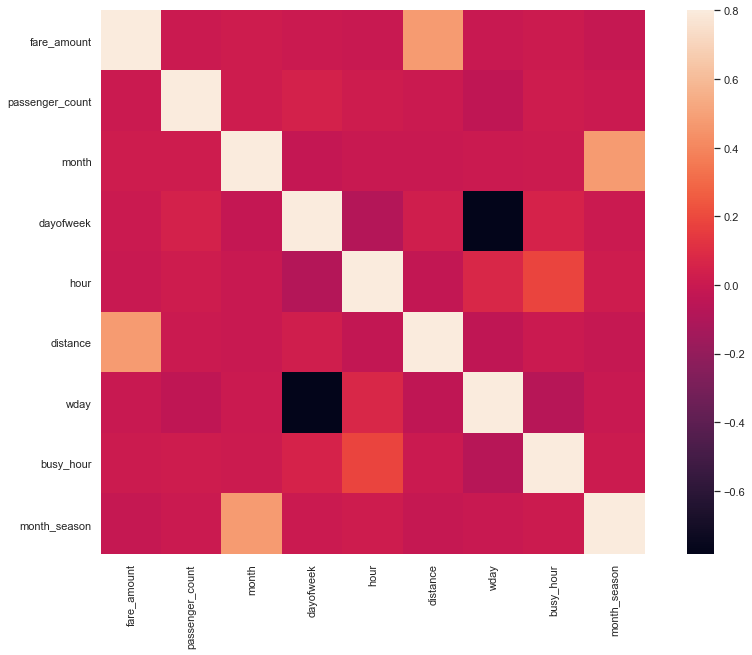

In [52]:
corrmat = df_train[numerical_col].corr()
f,ax = plt.subplots(figsize = (15,10))
sns.heatmap(corrmat,vmax=.8, square=True)

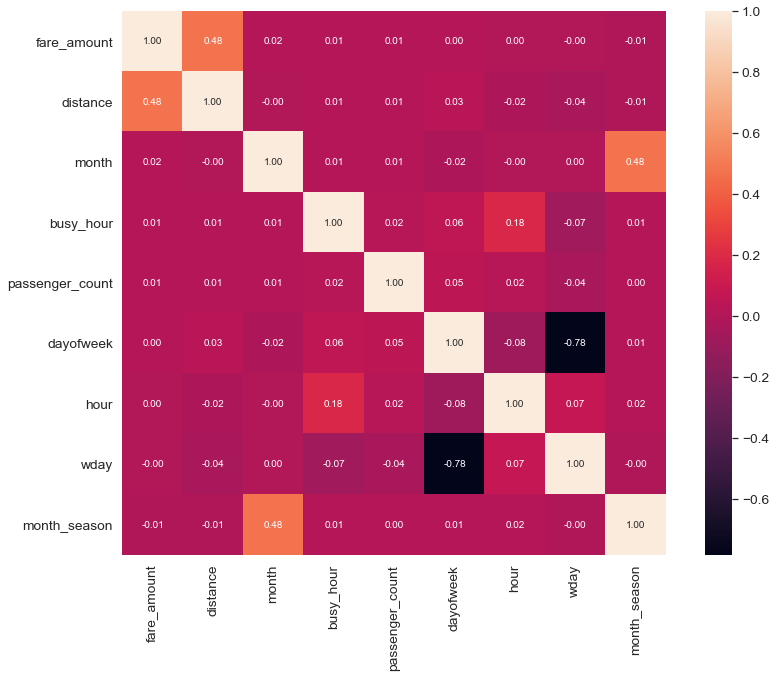

In [53]:
k=10
cls = corrmat.nlargest(k,'fare_amount')['fare_amount'].index
cm = np.corrcoef(df_train[cls].values.T)
sns.set(font_scale=1.25)
fig = plt.figure(figsize = (14,10))
hm = sns.heatmap(cm,cbar=True, annot=True, square=True, fmt='.2f',annot_kws={'size':10},yticklabels= cls.values, xticklabels= cls.values)


<h3>Scatterplot between 'Fare Amount' and correlated variables

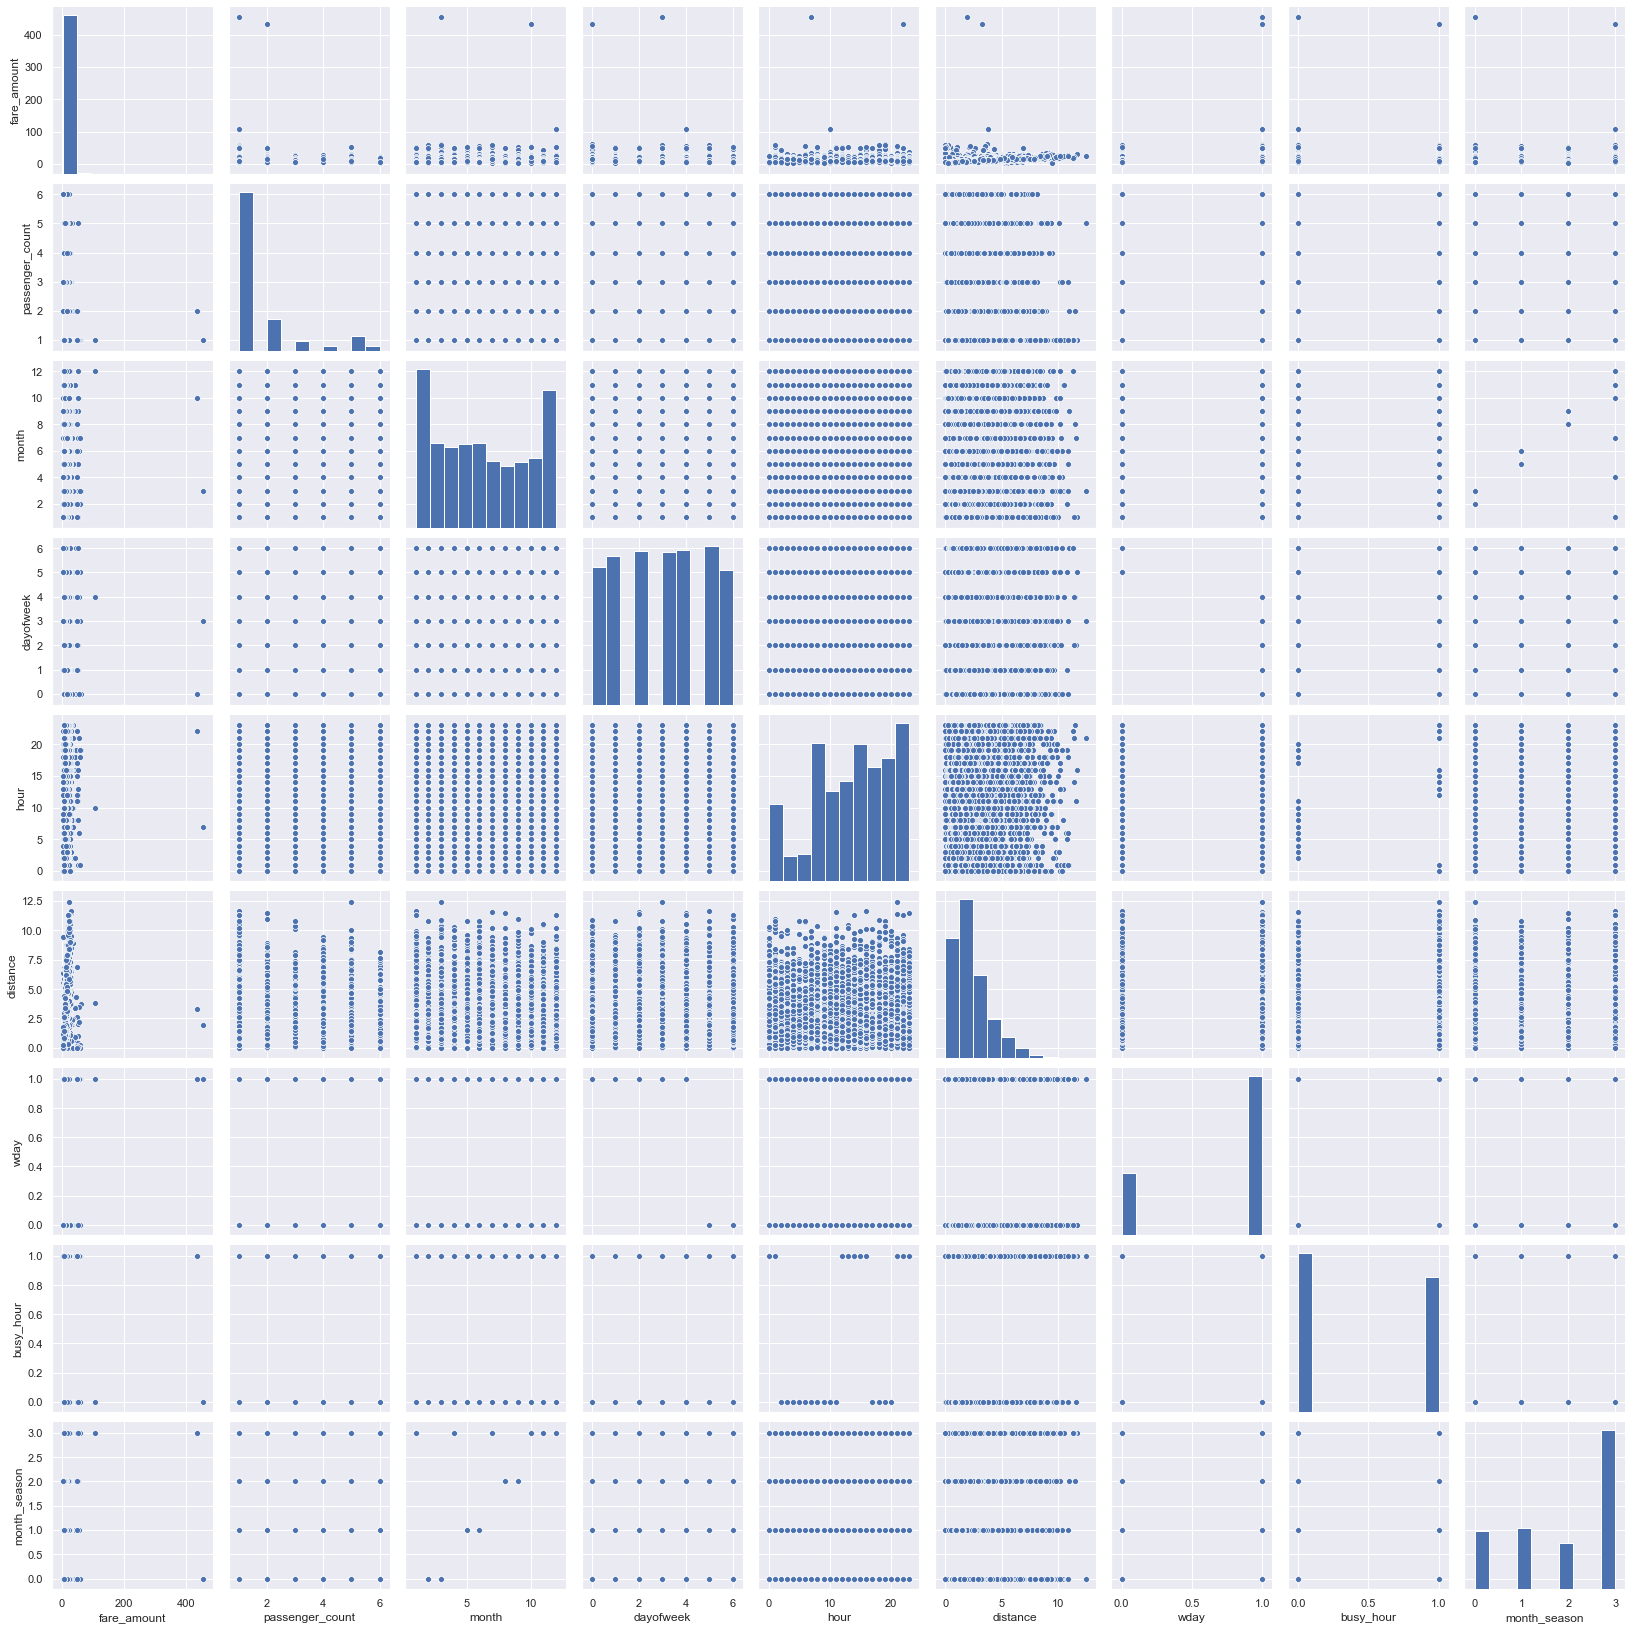

In [54]:

sns.set()
sns.pairplot(df_train[numerical_col],size=2.5)
plt.show()

fare_amount


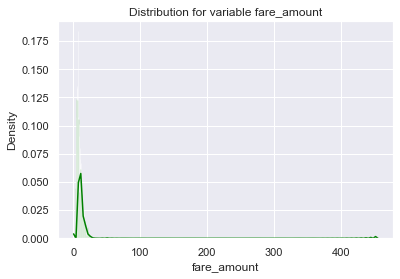

distance


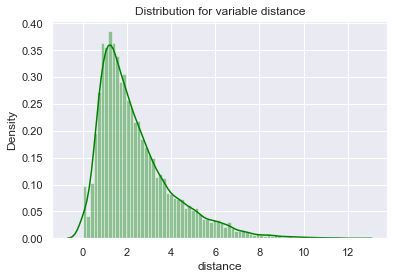

In [55]:
#normality check of training data is uniformly distributed or not
for i in ['fare_amount','distance']:
    print(i)
    sns.distplot(df_train[i],bins ='auto', color='green')
    plt.title("Distribution for variable " +i)
    plt.ylabel("Density")
    plt.show()

In [56]:
#observations: the distribution of 'Fare Amount' and 'Distance' are right skewed in order to get right predictions, transform the values using Logrithmic fxn

#Transforming the values of columns 'Fare Amount' and 'Distance' on train dataset

In [57]:
#since skewness of target variable is high, apply log transform to reduce the skewness
for i in ['fare_amount', 'distance']:
    df_train[i] = np.log1p(df_train[i])    

fare_amount


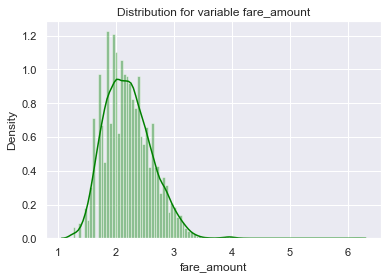

distance


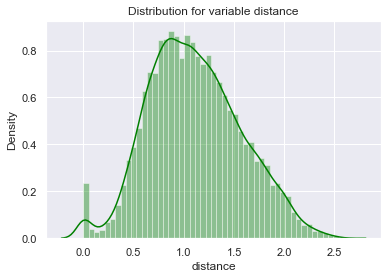

In [58]:
#Plotting the distribution after transformation

#normality re-check of training data is uniformly distributed or not
for i in ['fare_amount','distance']:
    print(i)
    sns.distplot(df_train[i],bins ='auto', color='green')
    plt.title("Distribution for variable " +i)
    plt.ylabel("Density")
    plt.show()

# 5. Building and Training Models

<h3>Split the data

In [59]:
feature_names = ['passenger_count',,'onroad_distance','onroad_time','aerial_distance','distance','month', 'dayofweek', 'hour', 'wday', 'busy_hour', 'month_season']

X= df_train[feature_names]
y= df_train['fare_amount']

In [68]:
from sklearn.model_selection import train_test_split 

#split into train and validation data
train_X,val_X, train_y,val_y = train_test_split(X,y,random_state=1,train_size=0.8)


In [95]:
#to check the residual error between actual and predicted values
from sklearn.metrics import mean_squared_error

#to find accuracy for regression model
from sklearn.metrics import r2_score

#for tuning hyper parameters
from sklearn.model_selection import GridSearchCV


<h3>5.1 Linear Refression Model

In [97]:
from sklearn.linear_model import LinearRegression

#Fit the model
model_lr = LinearRegression()

#fit the training data
model_lr.fit(train_X,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
#Predicting the model on training data
train_pred_lr = model_lr.predict(train_X)
train_pred_lr

array([1.72019675, 2.37697777, 2.33993544, ..., 2.29535854, 2.16932435,
       1.82999987])

In [99]:
#Predicting the model on validation data
val_pred_lr = pd.DataFrame(model_lr.predict(val_X))
val_pred_lr

,0
0,2.553300
1,1.908389
2,2.273580
3,2.145659
4,1.842587
...,...
2691,1.687883
2692,1.663294
2693,2.545951
2694,2.265976


In [100]:
#Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(val_y,val_pred_lr))


0.1783617288143888


In [101]:
#inspect your predictions and actual values from validation Data
print('Validation Prediction:\n',model_lr.predict(val_X.head()))
print('Actual Fare Amount from Validation Data:\n',val_y.head())

Validation Prediction:
 [2.55330037 1.90838921 2.27357956 2.14565916 1.84258745]
Actual Fare Amount from Validation Data:
 11724    2.442347
13897    1.960095
3224     2.292535
6192     2.251292
13939    1.504077
Name: fare_amount, dtype: float32


In [102]:
#calculating RMSE for train data
train_rmse_lr = np.sqrt(mean_absolute_error(train_y,train_pred_lr))

#calculating RMSE for validation data
val_rmse_lr = np.sqrt(mean_absolute_error(val_y,val_pred_lr))

print("RMSE for training data: ",train_rmse_lr)
print("RMSE for validation data: ",val_rmse_lr)

RMSE for training data:  0.4190368169393527
RMSE for validation data:  0.4223289343798135


In [104]:
#Calculate R2 score 
print("R2 score for training data: ",r2_score(train_y,train_pred_lr))
print("R2 score validation data: ",r2_score(val_y,val_pred_lr))

R2 score for training data:  0.6076098948151976
R2 score validation data:  0.5934157326031945


<h3>5.2 Decision Tree Model

In [105]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=1)

#fit model
model_dt.fit(train_X,train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [106]:
#Predicting the model on training data
train_pred_dt = model_dt.predict(train_X)
train_pred_dt

array([1.45861506, 2.25129175, 2.25129175, ..., 2.48490667, 2.14006615,
       1.84054971])

In [107]:
#Predicting the model on validation data
val_pred_dt = pd.DataFrame(model_dt.predict(val_X))
val_pred_dt

,0
0,2.862201
1,1.791759
2,2.564949
3,2.197225
4,1.945910
...,...
2691,1.360977
2692,1.360977
2693,3.113515
2694,2.397895


In [108]:
#calculate mean_absolute_error
print(mean_absolute_error(val_y,val_pred_dt))

0.24783605319456106


In [109]:
#inspect your predictions and actual values from validation Data
print('Validation Prediction:\n',model_dt.predict(val_X.head()))
print('Actual Fare Amount from Validation Data:\n',val_y.head())

Validation Prediction:
 [2.86220098 1.79175949 2.56494927 2.19722462 1.9459101 ]
Actual Fare Amount from Validation Data:
 11724    2.442347
13897    1.960095
3224     2.292535
6192     2.251292
13939    1.504077
Name: fare_amount, dtype: float32


In [110]:
#calculating RMSE for train data
train_rmse_dt = np.sqrt(mean_absolute_error(train_y,train_pred_dt))

#calculating RMSE for validation data
val_rmse_dt = np.sqrt(mean_absolute_error(val_y,val_pred_dt))

print("RMSE for training data: ",train_rmse_dt)
print("RMSE for validation data: ",val_rmse_dt)

RMSE for training data:  0.013471645603465175
RMSE for validation data:  0.49783135015239954


In [111]:
#Calculate R2 score 
print("R2 score for training data: ",r2_score(train_y,train_pred_dt))
print("R2 score validation data: ",r2_score(val_y,val_pred_dt))

R2 score for training data:  0.999625701392804
R2 score validation data:  0.19937852318693228


<h3>5.3 Random Forest Model

In [76]:
from sklearn.ensemble import RandomForestRegressor

#define Model
model_rf = RandomForestRegressor(random_state=1)

#fir the model
model_rf.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [77]:
#calculate mean_absolute_error 
rf_val_mae = mean_absolute_error(val_y,model_rf.predict(val_X))
print("Validation MAE :{}".format(rf_val_mae))

Validation MAE :0.18188525783455678


In [80]:
#inspect your predictions and actual values from validation Data
print('Validation Prediction:\n',model_rf.predict(val_X.head()))
print('Actual Fare Amount from Validation Data:\n',val_y.head())

Validation Prediction:
 [2.71803212 1.86944794 2.34343011 2.09736757 1.83982986]
Actual Fare Amount from Validation Data:
 11724    2.442347
13897    1.960095
3224     2.292535
6192     2.251292
13939    1.504077
Name: fare_amount, dtype: float32


In [112]:
#calculating RMSE for train data
train_rmse_rf = np.sqrt(mean_absolute_error(train_y,model_rf.predict(train_X)))

#calculating RMSE for validation data
val_rmse_rf = np.sqrt(mean_absolute_error(val_y,model_rf.predict(val_X)))

print("RMSE for training data: ",train_rmse_dt)
print("RMSE for validation data: ",val_rmse_dt)

RMSE for training data:  0.013471645603465175
RMSE for validation data:  0.49783135015239954


In [113]:
#Calculate R2 score 
print("R2 score for training data: ",r2_score(train_y,model_rf.predict(train_X)))
print("R2 score validation data: ",r2_score(val_y,model_rf.predict(val_X)))

R2 score for training data:  0.946250487367223
R2 score validation data:  0.6000174191151674


<h3>5.4 Gradient Boosting Regressor Model

In [114]:
from sklearn.ensemble import GradientBoostingRegressor

#define Model
model_gb = GradientBoostingRegressor(random_state=1)

#fir the model
model_gb.fit(train_X,train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [115]:
#Predicting the model on training data
train_pred_gb = model_gb.predict(train_X)
train_pred_gb

array([1.69213753, 2.30176365, 2.28714483, ..., 2.30436758, 2.18067841,
       1.79138189])

In [116]:
#Predicting the model on validation data
val_pred_gb = pd.DataFrame(model_gb.predict(train_X))
val_pred_gb

,0
0,1.692138
1,2.301764
2,2.287145
3,1.828683
4,2.998651
...,...
10776,2.044044
10777,2.382550
10778,2.304368
10779,2.180678


In [121]:
#calculate mean_absolute_error
#print(mean_absolute_error(val_y,val_pred_gb))

In [118]:
#inspect your predictions and actual values from validation Data
print('Validation Prediction:\n',model_gb.predict(val_X.head()))
print('Actual Fare Amount from Validation Data:\n',val_y.head())

Validation Prediction:
 [2.5984819  1.86742078 2.28544005 2.16576168 1.77084937]
Actual Fare Amount from Validation Data:
 11724    2.442347
13897    1.960095
3224     2.292535
6192     2.251292
13939    1.504077
Name: fare_amount, dtype: float32


In [122]:
#calculating RMSE for train data
train_rmse_gb = np.sqrt(mean_absolute_error(train_y,train_pred_gb))

#calculating RMSE for validation data
#val_rmse_gb = np.sqrt(mean_absolute_error(val_y,val_pred_gb))

print("RMSE for training data: ",train_rmse_gb)
#print("RMSE for validation data: ",val_rmse_gb)

RMSE for training data:  0.40076185749576404


In [123]:
#Calculate R2 score 
print("R2 score for training data: ",r2_score(train_y,train_pred_gb))
#print("R2 score validation data: ",r2_score(val_y,val_pred_gb))

R2 score for training data:  0.6841455998918204


<h3>5.5 K-Nearest Neighbour

In [125]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=10)
#fit the model
model_knn.fit(train_X,train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [126]:
#Predicting the model on training data
train_pred_knn = model_knn.predict(train_X)
train_pred_knn

array([1.9040651, 2.1506608, 2.245953 , ..., 2.1409547, 2.2006593,
       2.076314 ], dtype=float32)

In [127]:
#Predicting the model on training data
val_pred_knn = model_knn.predict(val_X)
val_pred_knn

array([2.2462428, 2.1591382, 2.1858685, ..., 2.3698459, 2.0658596,
       2.2009563], dtype=float32)

In [128]:
#calculate mean_absolute_error
print(mean_absolute_error(val_y,val_pred_knn))

0.2550094


In [129]:
#inspect your predictions and actual values from validation Data
print('Validation Prediction:\n',model_knn.predict(val_X.head()))
print('Actual Fare Amount from Validation Data:\n',val_y.head())

Validation Prediction:
 [2.2462428 2.1591382 2.1858685 2.138555  2.0709894]
Actual Fare Amount from Validation Data:
 11724    2.442347
13897    1.960095
3224     2.292535
6192     2.251292
13939    1.504077
Name: fare_amount, dtype: float32


In [130]:
#calculating RMSE for train data
train_rmse_knn = np.sqrt(mean_absolute_error(train_y,train_pred_knn))

#calculating RMSE for validation data
val_rmse_knn = np.sqrt(mean_absolute_error(val_y,val_pred_knn))

print("RMSE for training data: ",train_rmse_knn)
print("RMSE for validation data: ",val_rmse_knn)

RMSE for training data:  0.47797433
RMSE for validation data:  0.50498456


In [131]:
#Calculate R2 score 
print("R2 score for training data: ",r2_score(train_y,train_pred_knn))
print("R2 score validation data: ",r2_score(val_y,val_pred_knn))

R2 score for training data:  0.4574095339783044
R2 score validation data:  0.3343048776026557
